In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import pickle
import matplotlib.colors as colors
import datetime as dt
import pickle
from matplotlib.colors import BoundaryNorm
import glob
import pdb
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

import calendar
import sys
sys.path.append('/home/563/ab2313/MJO/functions')
import access_functions as af
import subphase_calc_functions as subphase_calc
import access_plot_functions as apf
import load_dataset as load
import phase_calc_functions as phase_calc
from importlib import reload
import miscellaneous as misc

In [2]:
awap = load.load_awap()

rmm = load.load_rmm()

In [3]:
# !!!!!!!!!! WARNING !!!!!!!!

if 0:
    awap_full = awap.copy(deep =  True)

In [103]:
awap = awap_full

In [104]:
awap

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, time: 19278)
Coordinates:
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * time     (time) datetime64[ns] 1911-01-01 1911-01-02 ... 2017-12-31
Data variables:
    precip   (time, lat, lon) float32 nan 2.7694564 4.730564 ... nan nan nan
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...

In [105]:
awap_q = awap.reduce(np.nanpercentile, q = 90, dim = 'time')

awap_extreme = awap.where(awap.precip >= awap_q.precip, drop = True)

In [106]:
rmm

<xarray.Dataset>
Dimensions:    (time: 16767)
Coordinates:
  * time       (time) datetime64[ns] 1974-06-01 1974-06-02 ... 2020-04-26
Data variables:
    RMM1       (time) float64 1.634 1.603 1.516 1.51 ... -0.2429 0.245 0.5514
    RMM2       (time) float64 1.203 1.015 1.086 1.036 ... -2.137 -2.101 -1.862
    phase      (time) int64 5 5 5 5 5 6 6 6 6 7 6 5 ... 1 1 1 1 1 1 2 2 2 2 3 3
    amplitude  (time) float64 2.029 1.897 1.865 1.831 ... 2.151 2.115 1.942

In [107]:
awap_sub = awap.where(awap.time.isin(rmm.time.values), drop = True)

In [109]:
awap_extreme_sub = awap_extreme.where(awap_extreme.time.isin(rmm.time.values), drop = True)

In [116]:
# awap_len = len(awap.time.values)

# awap = awap.isel(time = slice(int(np.ceil(awap_len/2)),int(awap_len)))

# Scotts

## Funtionalised

In [119]:
def SM_all(data):
    
    day_freq =  data.groupby('time.dayofweek').count()
    
    
    # Changing from a fequency to a relative frequency
    total_sum = day_freq.sum(dim = 'dayofweek')

    day_freq_n = day_freq/total_sum
    # The chance of rainfall on each day should be 1/0.7. How does the frequency actually compare to this.
    chance = 1.0/7
    day_freq_n_rel = day_freq_n/ chance

    # Bootstrapping

    years = np.unique(data.time.dt.year)
    num_years = len(years)


    stor = []
    loops = 1000

    for i in range(loops):
        year_sel = np.random.randint(low = years[0], high = years[-1], size  = np.round(num_years/2,0).astype(int))

        awap_sub = data.where(data.time.dt.year.isin(year_sel), drop = True)
        awap_sub_count = awap_sub.groupby('time.dayofweek').count()


        total_sum_sub = awap_sub_count.sum(dim = 'dayofweek')

        freq = awap_sub_count/total_sum_sub 

        stor.append(freq)


    freq_xr = xr.concat(stor, pd.Index(np.arange(1,loops + 1), name = 'run'))
    
    
    p05 = freq_xr.groupby('dayofweek').reduce(np.nanpercentile, dim = 'run', q = 5).mean(dim = 'dayofweek')
    p95 = freq_xr.groupby('dayofweek').reduce(np.nanpercentile, dim = 'run', q = 95).mean(dim = 'dayofweek')

    day_freq_n_bs = day_freq_n_rel.where(np.logical_or(day_freq_n.precip > p95,
                                                   day_freq_n.precip < p05))
    
    
    return day_freq, day_freq_n_rel, day_freq_n_bs, p05, p95

In [120]:
day_freq_full, day_freq_n_rel_full, day_freq_n_bs_full,p05_full, p95_full = SM_all(awap)

day_freq_full_extreme, day_freq_n_rel_full_extreme, day_freq_n_bs_full_extreme, p05_full_extreme, p95_full_extreme\
        = SM_all(awap_extreme)

In [121]:
day_freq_sub, day_freq_n_rel_sub, day_freq_n_bs_sub,p05_sub, p95_sub = SM_all(awap_sub)

day_freq_sub_extreme, day_freq_n_rel_sub_extreme, day_freq_n_bs_sub_extreme,p05_sub_extreme, p95_sub_extreme\
        = SM_all(awap_extreme_sub)

## Raw

In [63]:
day_freq =  awap.groupby('time.dayofweek').count()

In [64]:
day_freq

<xarray.Dataset>
Dimensions:    (dayofweek: 7, lat: 49, lon: 149)
Coordinates:
  * lat        (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon        (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * dayofweek  (dayofweek) int64 0 1 2 3 4 5 6
Data variables:
    precip     (dayofweek, lat, lon) int64 0 183 222 241 257 269 ... 0 0 0 0 0 0

In [65]:
# Changing from a fequency to a relative frequency
total_sum = day_freq.sum(dim = 'dayofweek')

day_freq_n = day_freq/total_sum
day_freq_n

<xarray.Dataset>
Dimensions:    (dayofweek: 7, lat: 49, lon: 149)
Coordinates:
  * lat        (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon        (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * dayofweek  (dayofweek) int64 0 1 2 3 4 5 6
Data variables:
    precip     (dayofweek, lat, lon) float64 nan 0.146 0.1506 ... nan nan nan

In [52]:
# The chance of rainfall on each day should be 1/0.7. How does the frequency actually compare to this.
chance = 1.0/7
day_freq_n_rel = day_freq_n/ chance
day_freq_n_rel 

<xarray.Dataset>
Dimensions:    (dayofweek: 7, lat: 49, lon: 149)
Coordinates:
  * lat        (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon        (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * dayofweek  (dayofweek) int64 0 1 2 3 4 5 6
Data variables:
    precip     (dayofweek, lat, lon) float64 nan 1.022 1.054 ... nan nan nan

In [53]:
# Bootstrapping

years = np.unique(awap.time.dt.year)
num_years = len(years)


stor = []
loops = 1000

for i in range(loops):
    year_sel = np.random.randint(low = years[0], high = years[-1], size  = np.round(num_years/2,0).astype(int))
    
    awap_sub = awap.where(awap.time.dt.year.isin(year_sel), drop = True)
    awap_sub_count = awap_sub.groupby('time.dayofweek').count()
    
    
    total_sum_sub = awap_sub_count.sum(dim = 'dayofweek')
    
    freq = awap_sub_count/total_sum_sub 
    
    stor.append(freq)
    

freq_xr = xr.concat(stor, pd.Index(np.arange(1,loops + 1), name = 'run'))

Standard Deviation base approach

In [54]:
# The standard deviation for each day, then mean across all days

std_bs = freq_xr.std(dim = 'run').mean(dim = 'dayofweek')

std_bs

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
Data variables:
    precip   (lat, lon) float64 nan 0.009332 0.008585 0.008085 ... nan nan nan

In [55]:
# The mean frequency
mean_freq = day_freq_n.mean(dim = 'dayofweek')
mean_freq

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
Data variables:
    precip   (lat, lon) float64 nan 0.1429 0.1429 0.1429 ... nan nan nan nan

In [56]:
upper_bound = mean_freq + 2 * std_bs
lower_bound = mean_freq - 2 * std_bs

In [38]:
day_freq_n_bs = day_freq_n_rel.where(np.logical_or(day_freq_n.precip > 2 * upper_bound,
                                               day_freq_n.precip < 2 * lower_bound))

Percentile Based Approach

In [130]:
day_freq_n_rel

<xarray.Dataset>
Dimensions:    (dayofweek: 7, lat: 49, lon: 149)
Coordinates:
  * lat        (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon        (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * dayofweek  (dayofweek) int64 0 1 2 3 4 5 6
Data variables:
    precip     (dayofweek, lat, lon) float64 nan 1.022 1.054 ... nan nan nan

In [134]:
day_freq_n

<xarray.Dataset>
Dimensions:    (dayofweek: 7, lat: 49, lon: 149)
Coordinates:
  * lat        (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon        (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * dayofweek  (dayofweek) int64 0 1 2 3 4 5 6
Data variables:
    precip     (dayofweek, lat, lon) float64 nan 0.146 0.1506 ... nan nan nan

In [133]:
p05 = freq_xr.groupby('dayofweek').reduce(np.nanpercentile, dim = 'run', q = 5).mean(dim = 'dayofweek')
p95 = freq_xr.groupby('dayofweek').reduce(np.nanpercentile, dim = 'run', q = 95).mean(dim = 'dayofweek')

day_freq_n_bs = day_freq_n_rel.where(np.logical_or(day_freq_n.precip > p95,
                                               day_freq_n.precip < p05))

In [41]:
day_freq_n_bs_2 = day_freq_n_rel.where(np.logical_and(day_freq_n.precip > p95,
                                               day_freq_n.precip < p05))

# Plots

## Sample Bar Plots

In [57]:
import calendar

In [95]:
dow = [calendar.day_abbr[i] for i in range(7)]
dow

['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [127]:
1/7

0.14285714285714285

In [140]:
(p95_full_extreme.sel(lat = -17.5, lon = 145, method = 'nearest')/(1/7)).precip.values

array(1.1727883)

In [181]:
data = day_freq_n_rel_full.sel(lat = lat, lon = 145, method = 'nearest').precip.values
data[6] = 0.94
data[3] = 0.99

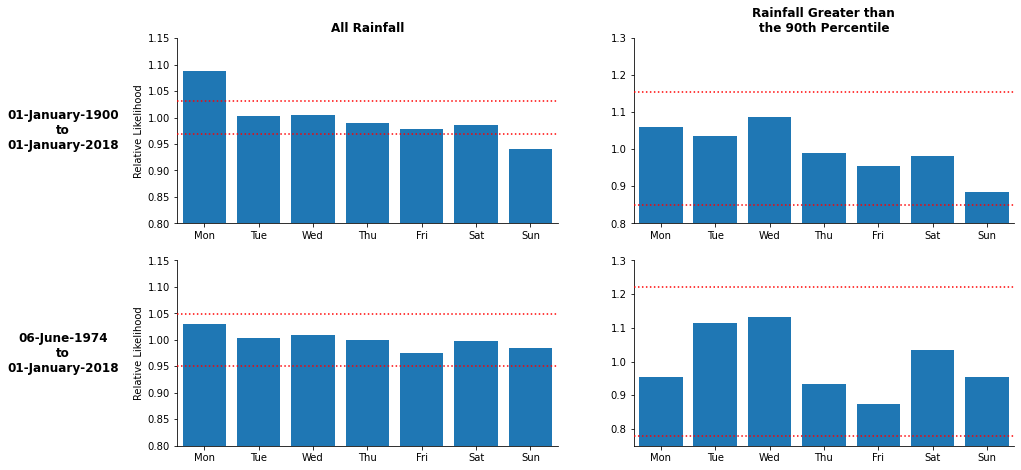

In [199]:
lat = -17
fig = plt.figure(figsize = (15,7.5))
gs = gridspec.GridSpec(2,2)
best_blue = '#9bc2d5'

ax = fig.add_subplot(gs[0])
data = day_freq_n_rel_full.sel(lat = lat, lon = 145, method = 'nearest').precip.values
ax.bar(np.arange(0,7),data)
upper = (p95_full.sel(lat = lat, lon = 145, method = 'nearest')/(1/7)).precip.values
lower = (p05_full.sel(lat = lat, lon = 145, method = 'nearest')/(1/7)).precip.values
ax.plot([-0.5,6.5],[upper, upper], color = 'r', zorder = 100, linestyle = ':')
ax.plot([-0.5,6.5],[lower, lower], color = 'r', zorder = 100, linestyle = ':')
ax.set_xlim(-0.5,6.5)
ax.set_ylim(0.8, 1.15);
ax.set_xticks(range(7));
ax.set_xticklabels(dow);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Relative Likelihood')
ax.annotate('01-January-1900\nto\n01-January-2018', xy = (-0.3,0.5), xycoords = 'axes fraction', weight = 'bold',
           ha = 'center', fontsize = 12, va = 'center')
ax.set_title('All Rainfall',weight = 'bold', size = 12)

ax = fig.add_subplot(gs[1])
ax.bar(np.arange(0,7),day_freq_n_rel_full_extreme.sel(lat = lat, lon = 145, method = 'nearest').precip)
upper = (p95_full_extreme.sel(lat = lat, lon = 145, method = 'nearest')/(1/7)).precip.values
lower = (p05_full_extreme.sel(lat = lat, lon = 145, method = 'nearest')/(1/7)).precip.values
ax.plot([-0.5,6.5],[upper, upper], color = 'r', zorder = 100, linestyle = ':')
ax.plot([-0.5,6.5],[lower, lower], color = 'r', zorder = 100, linestyle = ':')
ax.set_xlim(-0.5,6.5)
ax.set_ylim(0.8, 1.3);
ax.set_xticks(range(7));
ax.set_xticklabels(dow);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Rainfall Greater than\nthe 90th Percentile',weight = 'bold', size = 12)

ax = fig.add_subplot(gs[2])
ax.bar(np.arange(0,7),day_freq_n_rel_sub.sel(lat = lat, lon = 145, method = 'nearest').precip)
upper = (p95_sub.sel(lat = lat, lon = 145, method = 'nearest')/(1/7)).precip.values
lower = (p05_sub.sel(lat = lat, lon = 145, method = 'nearest')/(1/7)).precip.values
ax.plot([-0.5,6.5],[upper, upper], color = 'r', zorder = 100, linestyle = ':')
ax.plot([-0.5,6.5],[lower, lower], color = 'r', zorder = 100, linestyle = ':')
ax.set_ylim(0.8, 1.15);
ax.set_xlim(-0.5,6.5)
ax.set_xticks(range(7));
ax.set_xticklabels(dow);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Relative Likelihood')
ax.annotate('06-June-1974\nto\n01-January-2018', xy = (-0.3,0.5), xycoords = 'axes fraction', weight = 'bold',
           ha = 'center', fontsize = 12, va = 'center')


ax = fig.add_subplot(gs[3])
ax.bar(np.arange(0,7),day_freq_n_rel_sub_extreme.sel(lat = lat, lon = 145, method = 'nearest').precip)
upper = (p95_sub_extreme.sel(lat = lat, lon = 145, method = 'nearest')/(1/7)).precip.values
lower = (p05_sub_extreme.sel(lat = lat, lon = 145, method = 'nearest')/(1/7)).precip.values
ax.plot([-0.5,6.5],[upper, upper], color = 'r', zorder = 100, linestyle = ':')
ax.plot([-0.5,6.5],[lower, lower], color = 'r', zorder = 100, linestyle = ':')
ax.set_xlim(-0.5,6.5)
ax.set_ylim(0.75, 1.3);
ax.set_xticks(range(7));
ax.set_xticklabels(dow);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(f'../images/({lat})_(145)_bar_plot.png', dpi = 400, bbox_inches = 'tight', pad = 0)

<BarContainer object of 7 artists>

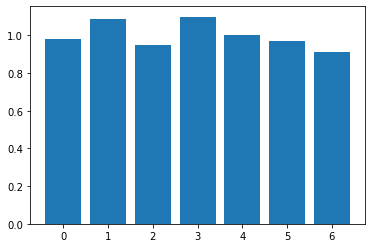

In [69]:
plt.bar(np.arange(0,7),day_freq_n_rel_ex.sel(lat = -17, lon = 143).precip)



<BarContainer object of 7 artists>

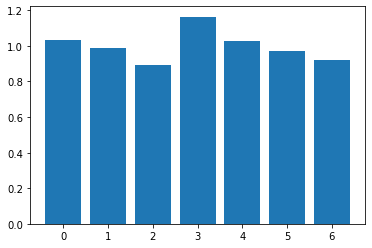

In [45]:
plt.bar(np.arange(0,7),day_freq_n_rel.sel(lat = -13, lon = 135).precip)

<BarContainer object of 7 artists>

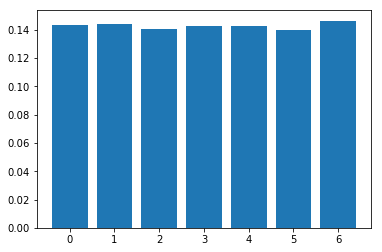

In [196]:
plt.bar(np.arange(0,7),day_freq_n.sel(lat = -15, lon = 135).precip)

<BarContainer object of 7 artists>

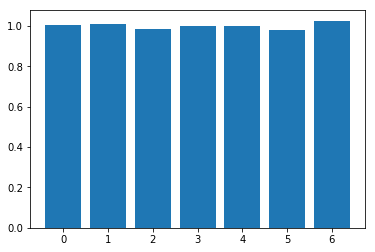

In [197]:
plt.bar(np.arange(0,7),day_freq_n_rel.sel(lat = -15, lon = 135).precip)

## Maps

In [130]:
if 1:
    half2_all_freq = day_freq_n_rel
    half2_all_freq_boot = day_freq_n_bs

In [110]:
if 0:
    half_all_freq = day_freq_n_rel
    half_all_freq_boot = day_freq_n_bs

In [81]:
if 0:
    ex_all_freq = day_freq_n_rel
    ex_all_freq_boot = day_freq_n_bs

In [ ]:
if 0:
    ex_sub_freq = day_freq_n_rel
    ex_sub_freq_boot = day_freq_n_bs

In [40]:
if 0:
    sub_freq = day_freq_n_rel
    sub_freq_boot = day_freq_n_bs

In [18]:
if 1:
    full_freq = day_freq_n_rel
    full_freq_boot = day_freq_n_bs

NameError: name 'sub_freq' is not defined

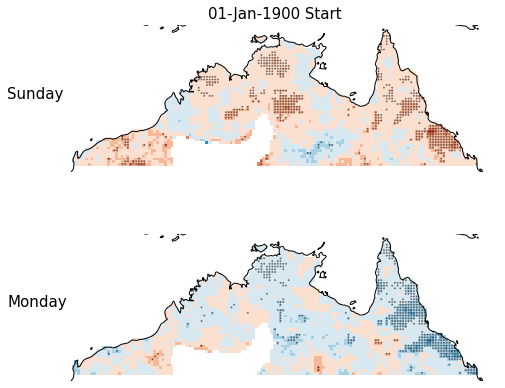

In [19]:
fig = plt.figure(figsize = (16,8))
days = [6,0]
gs = gridspec.GridSpec(3,2, wspace = 0, hspace = 0.3, height_ratios = [0.1,1,1])
data = day_freq_n_rel
data2 = day_freq_n_bs
vmax = np.max(data.precip)
vmin = np.min(data.precip)

col_num = 0
for l in range(2):
    if l == 1:
        data = sub_freq
        data2 = sub_freq_boot
    else:
        data = full_freq
        data2 = full_freq_boot        
        
    for i,day in enumerate(days):
        sb = data.sel(dayofweek = day)
        sb2 = data2.sel(dayofweek = day)

    #     levels = np.arange(0,vmax + 0.1,0.1)
    #     levels = np.linspace(vmin, vmax, 8)
        levels = np.arange(0.7,1.3, 0.05)
    #     custom_cmap = plt.cm.get_cmap('Reds', len(levels))(np.arange(len(levels)))
    #     cmap_custom = mpc.LinearSegmentedColormap.from_list("MyBlue", custom_cmap,len(levels))
        cmap_custom = plt.get_cmap('RdBu',len(levels))

    #     sb = sb.where(sb < vmax, 0)
        sb = sb.where(sb != 0, np.nan)
        sb2 = sb2.where(sb2 != 0, np.nan)

        ax = fig.add_subplot(gs[i + 1, col_num], projection = ccrs.PlateCarree())
        pdata = sb.precip.plot(ax = ax, add_colorbar = False, cmap = cmap_custom, levels = levels)

        ax.set_title
        #Significant Points( calendar.day_name[day], fontsize = 20)
        ax.outline_patch.set_visible(False)
        ax.coastlines(resolution = '50m')
        
        if i == 0 and col_num == 0:
            ax.set_title('01-Jan-1900 Start', size = 15)
            ax.annotate('Sunday', xy = (-0.1,0.5), xycoords = 'axes fraction', ha = 'left', size = 15)
        elif i == 0 and col_num == 1:
            ax.set_title('01-June-1974 Start', size = 15)
            
        else:
            ax.set_title('')


        if i == 1 and col_num == 0:
            ax.annotate('Monday', xy = (-0.1,0.5), xycoords = 'axes fraction', ha = 'left', size = 15)

        # plt.pcolor() needs an array for X and Y positions, generate with numpy.meshgrid
        X, Y = np.meshgrid(sb2.lon, sb2.lat)

        sig = sb2.where(~np.isfinite(sb2), 1)
        size = np.nan_to_num(sig.precip.values, 0)
        plt.scatter(X,Y, s = size, color= 'k', alpha = 0.4)
    col_num += 1
    
cax = plt.subplot(gs[0,:])
cbar = plt.colorbar(pdata, cax = cax, orientation = 'horizontal', boundaries = levels, extend = 'neither')
cbar.ax.set_title('Number of Raindays Compared to Relative Chance', fontsize = 12);
                  


# fig.savefig('extreme_Both_SM_stippled.png', dpi = 300)

Sunday-Monday Map

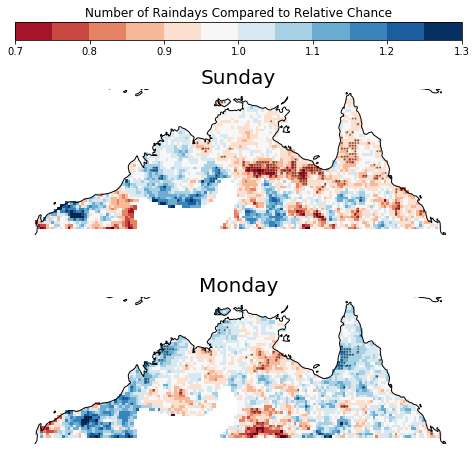

In [131]:
fig = plt.figure(figsize = (8,8))
days = [6,0]
gs = gridspec.GridSpec(3,1, wspace = 0, hspace = 0.3, height_ratios = [0.1,1,1])


data = half2_all_freq
data2 = half2_all_freq_boot

vmax = np.max(data.precip)
vmin = np.min(data.precip)
for i,day in enumerate(days):
    sb = data.sel(dayofweek = day)
    sb2 = data2.sel(dayofweek = day)
    
#     levels = np.arange(0,vmax + 0.1,0.1)
#     levels = np.linspace(vmin, vmax, 8)
    levels = np.arange(0.7,1.3, 0.05)
#     custom_cmap = plt.cm.get_cmap('Reds', len(levels))(np.arange(len(levels)))
#     cmap_custom = mpc.LinearSegmentedColormap.from_list("MyBlue", custom_cmap,len(levels))
    cmap_custom = plt.get_cmap('RdBu',len(levels))
    
#     sb = sb.where(sb < vmax, 0)
    sb = sb.where(sb != 0, np.nan)
    sb2 = sb2.where(sb2 != 0, np.nan)
    
    ax = fig.add_subplot(gs[i + 1], projection = ccrs.PlateCarree())
    pdata = sb.precip.plot(ax = ax, add_colorbar = False, cmap = cmap_custom, levels = levels)
    
    ax.set_title( calendar.day_name[day], fontsize = 20)
    ax.outline_patch.set_visible(False)
    ax.coastlines(resolution = '50m')
    
    
    
    #Significant Points


    # plt.pcolor() needs an array for X and Y positions, generate with numpy.meshgrid
    X, Y = np.meshgrid(sb2.lon, sb2.lat)

    sig = sb2.where(~np.isfinite(sb2), 1)
    size = np.nan_to_num(sig.precip.values, 0)
    plt.scatter(X,Y, s = size, color= 'k', alpha = 0.4)
    
    
cax = plt.subplot(gs[0])
cbar = plt.colorbar(pdata, cax = cax, orientation = 'horizontal', boundaries = levels, extend = 'neither')
cbar.ax.set_title('Number of Raindays Compared to Relative Chance', fontsize = 12);

fig.savefig('first_half2_SM.png', dpi = 300)

All Days Map

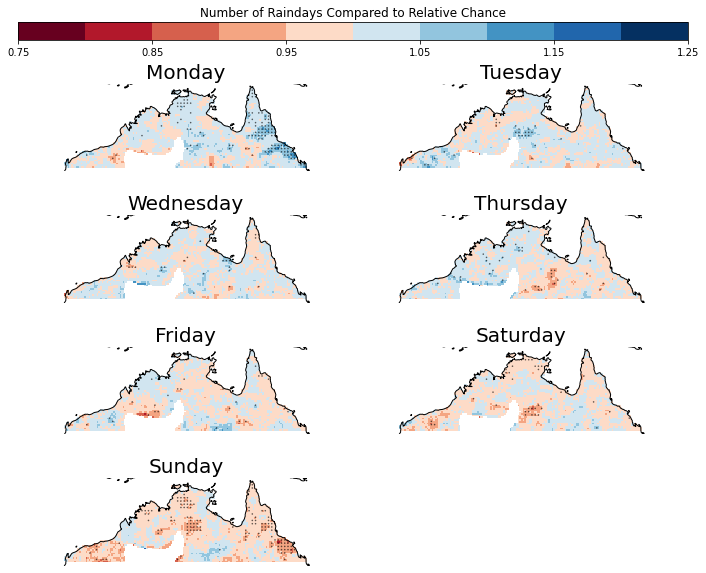

In [25]:
fig = plt.figure(figsize = (12,10))
days = day_freq_n.dayofweek.values
gs = gridspec.GridSpec(5,2, wspace = 0, hspace = 0.6, height_ratios = [0.2,1,1,1,1])

data = full_freq
data2 = full_freq_boot


vmax = np.max(data.precip)
vmin = np.min(data.precip)
for i,day in enumerate(days):
    sb = data.sel(dayofweek = day)
    sb2 = data2.sel(dayofweek = day)
    
#     levels = np.arange(0,vmax + 0.1,0.1)
#     levels = np.linspace(vmin, vmax, 8)
    levels = np.arange(0.75,1.3, 0.05)
#     custom_cmap = plt.cm.get_cmap('Reds', len(levels))(np.arange(len(levels)))
#     cmap_custom = mpc.LinearSegmentedColormap.from_list("MyBlue", custom_cmap,len(levels))
    cmap_custom = plt.get_cmap('RdBu',len(levels))
    
#     sb = sb.where(sb < vmax, 0)
    sb = sb.where(sb != 0, np.nan)
    sb2 = sb2.where(sb2 != 0, np.nan)
    
    ax = fig.add_subplot(gs[i + 2], projection = ccrs.PlateCarree())
    pdata = sb.precip.plot(ax = ax, add_colorbar = False, cmap = cmap_custom, levels = levels)
    
    ax.set_title( calendar.day_name[day], fontsize = 20)
    ax.outline_patch.set_visible(False)
    ax.coastlines(resolution = '50m')
    
    
    
    #Significant Points


    # plt.pcolor() needs an array for X and Y positions, generate with numpy.meshgrid
    X, Y = np.meshgrid(sb2.lon, sb2.lat)

    sig = sb2.where(~np.isfinite(sb2), 1)

    size = np.nan_to_num(sig.precip.values, 0)
    size[::2] = 0
    size = np.transpose(size)
    size[::2] = 0
    size = np.transpose(size)
    plt.scatter(X,Y, s = size/3, color= 'k', alpha = 0.6)
    
    
cax = plt.subplot(gs[0:2])
cbar = plt.colorbar(pdata, cax = cax, orientation = 'horizontal', boundaries = levels, extend = 'neither')
cbar.ax.set_title('Number of Raindays Compared to Relative Chance', fontsize = 12);

# fig.savefig('first_half2_all.png', dpi = 300)